In [ ]:
%%capture
!pip install --upgrade datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import pickle

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
def clean_text(text):
        # Remover URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

        # Remover emails
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

        # Remover numeros
        text = re.sub(r'\d+', '', text)

        # Remover pontuação
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        # Normalizar espaços
        text = re.sub(r'\s+', ' ', text)

        # Lower case
        text = text.lower()

        return text.strip()

In [ ]:
def prepare_features(max_features):

        vectorizers = {}

        # N-gramas de caracteres
        vectorizers['char_ngrams'] = TfidfVectorizer(
            analyzer='char',
            ngram_range=(1, 3),
            max_features=max_features,
            lowercase=True
        )

        # N-gramas de palavras
        vectorizers['word_ngrams'] = TfidfVectorizer(
            analyzer='word',
            ngram_range=(1, 2),
            max_features=max_features,
            lowercase=True
        )

        return vectorizers

In [ ]:
def collect_data(languages=[], samples_per_lang=1000, min_chars=50, max_chars=500):

        print("Coletando dados do OSCAR...")

        data = []
        labels = []

        for lang in languages:
            print(f"Coletando amostras para {lang}...")

            dataset = load_dataset(
                "oscar-corpus/OSCAR-2301",
                lang,
                split="train",
                streaming=True,
                trust_remote_code=True
            )

            lang_samples = []
            count = 0

            for sample in dataset:
                text = sample['text'].strip()

                if min_chars <= len(text) <= max_chars:
                    text = clean_text(text)
                    if len(text) >= min_chars:
                        lang_samples.append(text)
                        count += 1

                        if count >= samples_per_lang:
                            break

            print(f"Coletadas {len(lang_samples)} amostras para {lang}")

            data.extend(lang_samples)
            labels.extend([lang] * len(lang_samples))

        print(f"\nTotal de amostras coletadas: {len(data)}")
        print("\nDistribuição por idioma:")
        lang_counts = pd.Series(labels).value_counts()
        print(lang_counts.to_string())
        print("-" * 50)

        return data, labels

In [ ]:
def train_models(X_train, X_test, y_train, y_test, vectorizers):

        print("\nTreinando modelos...")

        print(f"Total de amostras de treino: {len(X_train)}")
        print(f"\nTotal de amostras de teste: {len(X_test)}")

        test_results = []

        best_final_model = None
        best_test_accuracy = 0.0
        best_model_name = ""

        models_config = {
            'naive_bayes': {
                'model': MultinomialNB(),
                'params': {
                    'classifier__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
                }
            },
            'logistic_regression': {
                'model': LogisticRegression(max_iter=1000),
                'params': {
                    'classifier__C': [0.1, 1, 10, 100],
                    'classifier__penalty': ['l1', 'l2'],
                    'classifier__solver': ['liblinear', 'saga']
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'classifier__n_estimators': [50, 100, 200],
                    'classifier__max_depth': [10, 20, None],
                    'classifier__min_samples_split': [2, 5, 10]
                }
            }
        }

        for vec_name, vectorizer in vectorizers.items():
            for model_name, model_info in models_config.items():
                full_name = f"{model_name}_{vec_name}"
                print(f"Treinando {model_name} com {vec_name}...")

                pipeline = Pipeline([
                    ('vectorizer', vectorizer),
                    ('classifier', model_info['model'])
                ])

                grid_search = GridSearchCV(
                              pipeline,
                              model_info['params'],
                              cv=3,
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=1
                )

            grid_search.fit(X_train, y_train)

            best_tuned_model = grid_search.best_estimator_

            print("Avaliando o modelo otimizado no conjunto de teste...")
            test_accuracy = best_tuned_model.score(X_test, y_test)
            print(f"Acurácia no teste: {test_accuracy:.4f}")

            test_results.append({
                'model_name': full_name,
                'test_accuracy': test_accuracy,
                'cv_score_on_train': grid_search.best_score_,
            })

            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                best_final_model = best_tuned_model
                best_model_name = full_name

            results_df = pd.DataFrame(test_results)
            results_df = results_df.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)
            print(results_df)

            print("\n" + "*"*50)
            print(f"Melhor modelo encontrado: {best_model_name}")
            print(f"Modelo: '{best_model_name}'")
            print(f"Acurácia no conjunto de teste: {best_test_accuracy:.4f}")
            print("*"*50)

        return best_final_model, results_df

In [ ]:
def detailed_evaluation(X_test, y_test, best_model, languages=[]):

        print("\nAvaliação do melhor modelo...")

        y_pred = best_model.predict(X_test)

        print("\nRelatório de Classificação:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred, labels=languages)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=languages, yticklabels=languages)
        plt.title('Matriz de Confusão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()

        print("-" * 50)

        return classification_report(y_test, y_pred, output_dict=True)

In [ ]:
def analyze_errors(X_test, y_test, best_model):

        print("\nAnalise de Erros...")

        y_pred = best_model.predict(X_test)

        # Encontrar erros
        errors = []
        for i, (real, pred) in enumerate(zip(y_test, y_pred)):
            if real != pred:
                errors.append({
                    'text': X_test[i][:200] + '...',
                    'real': real,
                    'predicted': pred,
                    'length': len(X_test[i])
                })

        errors_df = pd.DataFrame(errors)

        if len(errors_df) > 0:
            print(f"Total de erros: {len(errors_df)}")
            print("\nErros mais comuns:")
            error_pairs = errors_df.groupby(['real', 'predicted']).size().sort_values(ascending=False)
            print(error_pairs.head(10))

            print("\nExemplos de erros:")
            for i, row in errors_df.head(5).iterrows():
                print(f"Real: {row['real']}, Predito: {row['predicted']}")
                print(f"Texto: {row['text']}")
                print("-" * 50)
        else:
          return None

        return errors_df

In [ ]:
def predict(best_model, texts):

        if isinstance(texts, str):
            texts = [texts]

        predictions = best_model.predict(texts)
        probabilities = best_model.predict_proba(texts)

        results = []
        for i, text in enumerate(texts):
            pred_lang = predictions[i]
            confidence = max(probabilities[i])

            results.append({
                'text': text[:100] + '...' if len(text) > 100 else text,
                'predicted_language': pred_lang,
                'confidence': confidence
            })

        return results

In [ ]:
def save_model(best_model, languages=[], filepath='language_detection_model.pkl'):
        model_data = {
            'model': best_model,
            'languages': languages
        }

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"Modelo salvo em {filepath}")

In [ ]:
def load_model(filepath='language_identifier_model.pkl'):
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        print(f"Modelo carregado de {filepath}")
        return model_data['model']

In [ ]:
def language_identifier(samples, languages=[]):

    # Prepara os vetorizadores
    vectorizers = prepare_features(5000)

    # Coleta os dados e limpa os textos
    data, labels = collect_data(samples_per_lang=samples, languages=languages)

    # Separa os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

    # Treina os modelos
    best_model, models = train_models(X_train, X_test, y_train, y_test, vectorizers)

    # Avalia o melhor modelo
    detailed_evaluation(X_test, y_test, best_model, languages=languages)

    # Analisa os erros
    analyze_errors(X_test, y_test, best_model)

    # Testa o modelo com exemplos
    test_texts = [
            "Este é um exemplo de texto em português brasileiro.",
            "This is an example of English text for testing.",
            "Esto es un ejemplo de texto en español.",
            "Ceci est un exemple de texte en français.",
            "Dies ist ein Beispiel für deutschen Text."
        ]

    print("\nTeste com exemplos:")
    predictions = predict(best_model, test_texts)
    for pred in predictions:
        print(f"Texto: {pred['text']}")
        print(f"Idioma: {pred['predicted_language']} (Confiança: {pred['confidence']:.3f})")
        print("-" * 50)

    return save_model(best_model, languages)

Coletando dados do OSCAR...
Coletando amostras para pt...


README.md:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

OSCAR-2301.py:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

Coletadas 5000 amostras para pt
Coletando amostras para en...
Coletadas 5000 amostras para en
Coletando amostras para es...
Coletadas 5000 amostras para es
Coletando amostras para fr...
Coletadas 5000 amostras para fr
Coletando amostras para de...
Coletadas 5000 amostras para de

Total de amostras coletadas: 25000

Distribuição por idioma:
pt    5000
en    5000
es    5000
fr    5000
de    5000
--------------------------------------------------

Treinando modelos...
Total de amostras de treino: 20000

Total de amostras de teste: 5000
Treinando naive_bayes com char_ngrams...
Treinando logistic_regression com char_ngrams...
Treinando random_forest com char_ngrams...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Avaliando o modelo otimizado no conjunto de teste...
Acurácia no teste: 0.9982
                  model_name  test_accuracy  cv_score_on_train
0  random_forest_char_ngrams         0.9982             0.9983

**************************************************
Melhor mod

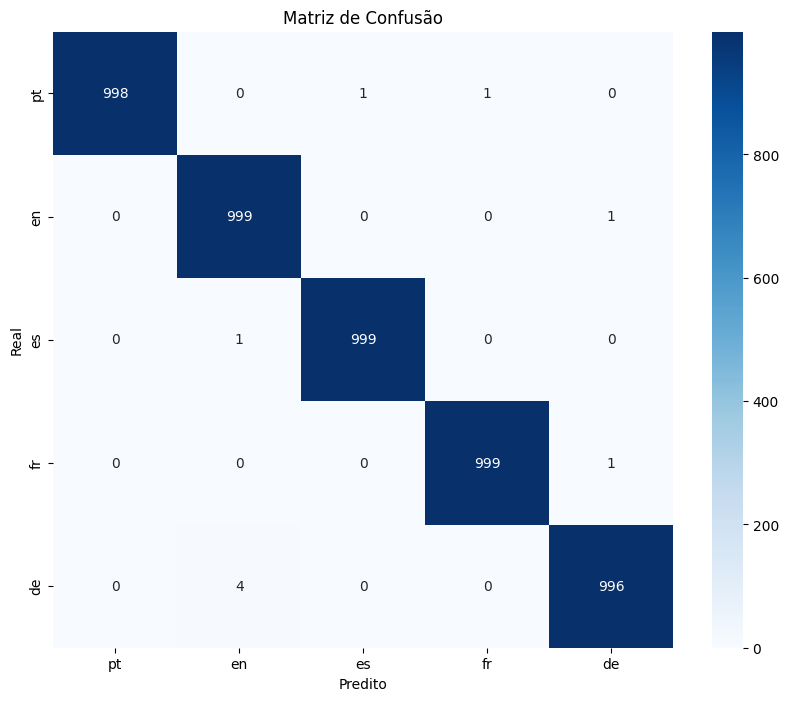

--------------------------------------------------

Analise de Erros...
Total de erros: 9

Erros mais comuns:
real  predicted
de    en           4
en    de           1
es    en           1
fr    de           1
pt    es           1
      fr           1
dtype: int64

Exemplos de erros:
Real: de, Predito: en
Texto: your ip address is blocked from accessing this system if you think this is a mistake contact and provide the mentioned ip address ihre ipadresse wurde vom system automatisch blockiert wenn sie dies fu...
--------------------------------------------------
Real: pt, Predito: fr
Texto: ano qualquer ou mais recente ou mais recente ou mais recente ou mais recente ou mais recente ou mais recente ou mais recente ou mais recente ou mais recente ou mais recente ou mais recente ou mais rec...
--------------------------------------------------
Real: pt, Predito: es
Texto: todos os direitos de autor do conteúdo capacity for conservation todos os direitos reservados o website capacity for c

In [ ]:
language_identifier(samples=5000, languages=['pt', 'en', 'es', 'fr', 'de'])

In [ ]:
print("\nTestando com o modelo salvo...")
best_model=load_model(filepath='language_detection_model.pkl')

# Lista de textos para testar
textos_de_teste = [
    "Este é um ótimo exemplo para testar a funcionalidade do nosso modelo.",
    "This is an excellent example to test the functionality of our model.",
    "Das ist ein hervorragendes Beispiel, um die Funktionalität unseres Modells zu testen.",
    "Ceci est un excellent exemple pour tester la fonctionnalité de notre modèle.",
    "Este es un excelente ejemplo para probar la funcionalidad de nuestro modelo.",
    "Programming in Python is both fun and powerful.",
    "La cuisine française est célèbre dans le monde entier.",
    "danke shaun",
    "hallo, wie geths"

]

# Obter as predições
predictions = predict(best_model, textos_de_teste)

# Exibir os resultados
for p in predictions:
    print(f"Texto: {p['text']}")
    print(f"✅Idioma Previsto: {p['predicted_language'].upper()} (Confiança: {p['confidence']:.3f})")
    print("-" * 50)


Testando com o modelo salvo...
Modelo carregado de language_detection_model.pkl
Texto: Este é um ótimo exemplo para testar a funcionalidade do nosso modelo.
✅Idioma Previsto: PT (Confiança: 0.795)
--------------------------------------------------
Texto: This is an excellent example to test the functionality of our model.
✅Idioma Previsto: EN (Confiança: 0.920)
--------------------------------------------------
Texto: Das ist ein hervorragendes Beispiel, um die Funktionalität unseres Modells zu testen.
✅Idioma Previsto: DE (Confiança: 0.835)
--------------------------------------------------
Texto: Ceci est un excellent exemple pour tester la fonctionnalité de notre modèle.
✅Idioma Previsto: FR (Confiança: 0.930)
--------------------------------------------------
Texto: Este es un excelente ejemplo para probar la funcionalidad de nuestro modelo.
✅Idioma Previsto: ES (Confiança: 0.795)
--------------------------------------------------
Texto: Programming in Python is both fun and power

In [ ]:
"